# Quantile Regression on Synthetic Data
This notebooks shows the diagnostic tools applied to quantile regression.
For details, see https://arxiv.org/abs/2202.12780.

## 1. Data and Models
We start by creating an artificial dataset with an asymmetric distribution such that mean and median are very different.
Then, we fit a linear model and gradient boosted trees for the **75%-quantile**.

best alpha for linear quantile regression = 0.0018329807108324356


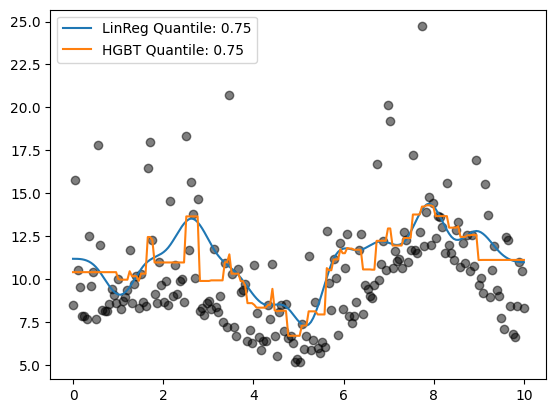

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer


quantile_level = 0.75

def create_data(n, rng):    
    x = np.linspace(start=0, stop=10, num=200)
    y_true_mean = 10 + 0.5 * x * np.sin(x)
    a = 5
    y = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))
    return y, x

rng = np.random.RandomState(42)
y_train, x_train = create_data(200, rng)
y_test, x_test = create_data(100, rng)
X_train, X_test = x_train[:, np.newaxis], x_test[:, np.newaxis]

m_linear = GridSearchCV(
    estimator=make_pipeline(
        SplineTransformer(degree=3, n_knots=20),
        QuantileRegressor(quantile=quantile_level, solver="highs"),
    ),
    param_grid={"quantileregressor__alpha": np.logspace(-4, 0, 20)},
    cv=5,
).fit(X_train, y_train)
print(
    "best alpha for linear quantile regression = "
    f"{m_linear.best_params_['quantileregressor__alpha']}"
)
m_hgbt = HistGradientBoostingRegressor(
    loss="quantile", quantile=quantile_level
).fit(X_train, y_train)


fig, ax = plt.subplots()
ax.scatter(x_train, y_train, color="black", alpha=0.5)
ax.plot(x_train, m_linear.predict(X_train), label=f"LinReg Quantile: {quantile_level}")
ax.plot(x_train, m_hgbt.predict(X_train), label=f"HGBT Quantile: {quantile_level}")
ax.legend()

## 2. Calibration Assessment
First, we look at the calibration in total, i.e. neither conditioning on a feature nor on the predictions.
We want to predict the 75%-quantile, so we expect that 25% of the data lie above and 75% below the model predictions.
This is what the [identification function](https://lorentzenchr.github.io/model-diagnostics/reference/model_diagnostics/calibration/identification/#model_diagnostics.calibration.identification.identification_function) for quantiles actually calculates such that a value of 0 is ideal.
Note that the identification function is implicitly called in [`compute_bias`](https://lorentzenchr.github.io/model-diagnostics/reference/model_diagnostics/calibration/identification/#model_diagnostics.calibration.identification.compute_bias) as well as [`plot_bias`](https://lorentzenchr.github.io/model-diagnostics/reference/model_diagnostics/calibration/plots/#model_diagnostics.calibration.plots.plot_bias).

model,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,f64,u32,f64,f64,f64
"""linear_quant_r…",0.005,200,200.0,0.030488,0.869899
"""hgbt_quant_reg…",0.0,200,200.0,0.030695,1.0


Text(0.5, 1.0, 'Bias Plot on Training Set')

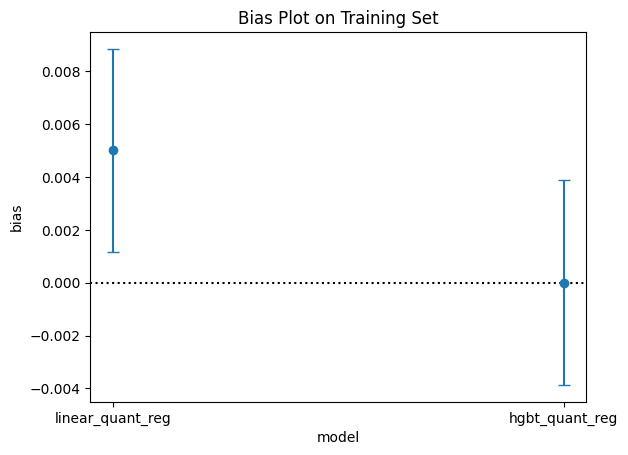

In [2]:
from model_diagnostics.calibration import compute_bias, plot_bias, plot_reliability_diagram

df = pl.DataFrame({
    "linear_quant_reg": m_linear.predict(X_train),
    "hgbt_quant_reg": m_hgbt.predict(X_train),
})

display(compute_bias(y_obs=y_train, y_pred=df, functional="quantile", level=quantile_level))

ax = plot_bias(
    y_obs=y_train, y_pred=df, functional="quantile", level=quantile_level,confidence_level=1 - 0.9
)
ax.set_title("Bias Plot on Training Set")

By setting a very small confidence level $\alpha$, such that $1-\alpha$ is in between the p-values, we see that the confidence interval of the linear model does not reach the 0-line.

We go on by investiating auto-calibration with the classical tool: a reliability diagram.

CPU times: user 1.98 s, sys: 88.6 ms, total: 2.07 s
Wall time: 1.96 s


Text(0.5, 1.0, 'Reliability Diagram on Training Set')

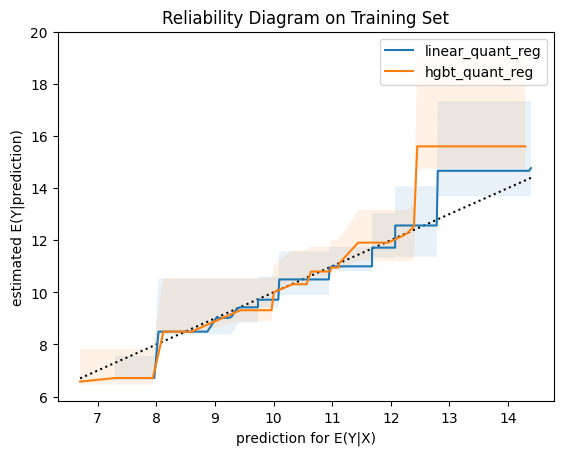

In [3]:
%%time
ax = plot_reliability_diagram(
    y_train,
    df,
    functional="quantile",
    level=quantile_level,
    n_bootstrap=100,
)
ax.set_ylim(None, 20)
ax.set_title("Reliability Diagram on Training Set")

The reliability diagram shows reasonable auto-calibration for both models.
For large predicted values, the linear model seems to be a bit better.

We conclude the assessment of calibration by a bias plot conditional on our single feature.

Text(0.5, 1.0, 'Bias Plot conditional on prediction on Training Set')

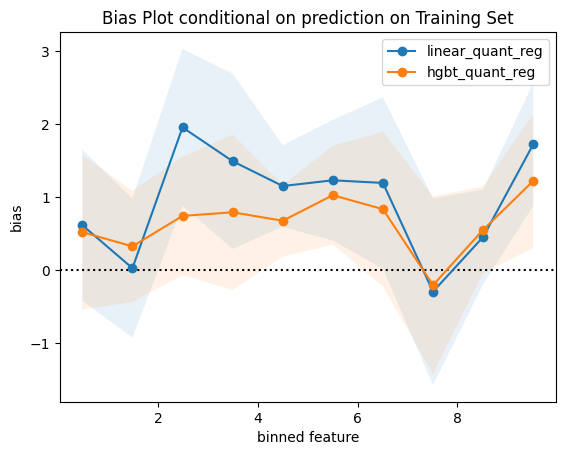

In [4]:
ax = plot_bias(y_obs=y_train, y_pred=df, feature=x_train, confidence_level=0.9)
ax.set_title("Bias Plot conditional on prediction on Training Set")

Here, the HGBT model seems a bit better calibrated.

## 3. Comparison of Model Performance

We use the standard loss function for quantile regression: the pinball loss.
Furthermore, as is standard, we do this analysis out-of-sample, i.e. using the test data set.

We report not only the pinball loss or score, but also the additive score decomposition: `score = miscalibration - discrimination + uncertainty`.

In [5]:
from model_diagnostics.scoring import decompose, plot_murphy_diagram, PinballLoss


pbl = PinballLoss(level=quantile_level)
df = pl.DataFrame({
    "linear_quant_reg": m_linear.predict(X_test),
    "hgbt_quant_reg": m_hgbt.predict(X_test),
})
decompose(y_obs=y_test, y_pred=df, scoring_function=pbl).sort("score")

model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""linear_quant_r…",0.088421,0.260633,1.075195,0.902983
"""hgbt_quant_reg…",0.056078,0.206818,1.075195,0.924455


The linear model has a better (lower) out-of-sample score (or loss).
While the HGBT has a better miscalibration term (smaller is better), the dominating term is the discrimination (larger is better) where the linear model is clearly superior.

Does the ranking of the models change with the choice of a scoring function?
This can be analysed by means of the Murphy diagram.
The x-axis `eta` specifies different scoring/loss functions, all consistent for the 75%-quantile.

<Axes: title={'center': 'Murphy Diagram'}, xlabel='eta', ylabel='score'>

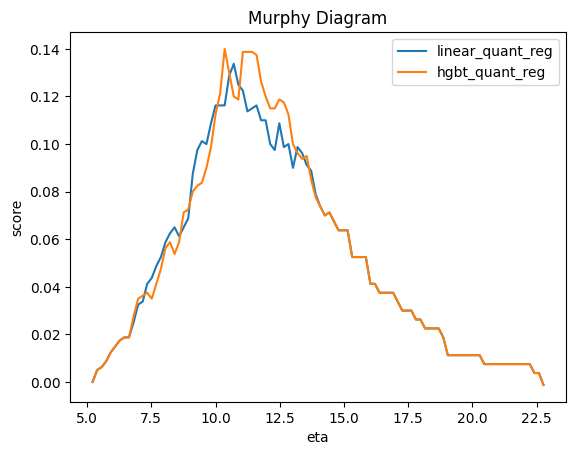

In [6]:
plot_murphy_diagram(y_obs=y_test, y_pred=df, functional="quantile", level=quantile_level)

The linear model seems in deed be superior over a range of `eta` values.